In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA


In [11]:
# Load Series
GOOGL=pd.read_csv("E:/Laurea Magistrale/Artificial intelligence and deep learning/Esame/Financial Series/GOOGL.csv")
NKE = pd.read_csv("E:/Laurea Magistrale/Artificial intelligence and deep learning/Esame/Financial Series/NKE.csv")
HD = pd.read_csv("E:/Laurea Magistrale/Artificial intelligence and deep learning/Esame/Financial Series/HD.csv")
JPM = pd.read_csv("E:/Laurea Magistrale/Artificial intelligence and deep learning/Esame/Financial Series/JPM.csv")
BA= pd.read_csv("E:/Laurea Magistrale/Artificial intelligence and deep learning/Esame/Financial Series/BA.csv")
JNJ = pd.read_csv("E:/Laurea Magistrale/Artificial intelligence and deep learning/Esame/Financial Series/JNJ.csv")
AAPL=pd.read_csv("E:/Laurea Magistrale/Artificial intelligence and deep learning/Esame/Financial Series/AAPL.csv")
INTC=pd.read_csv("E:/Laurea Magistrale/Artificial intelligence and deep learning/Esame/Financial Series/INTC.csv")
MCD=pd.read_csv("E:/Laurea Magistrale/Artificial intelligence and deep learning/Esame/Financial Series/MCD.csv")
TRV=pd.read_csv("E:/Laurea Magistrale/Artificial intelligence and deep learning/Esame/Financial Series/TRV.csv")

In [12]:
#GOOGL.info()
# faccio un merge verticale dei dati, creo la colonna di indentificazione del titolo e formatto la data
GOOGL.insert(7,column="Stock",value=np.repeat("GOOGL",3525))
NKE.insert(7,column="Stock",value=np.repeat("NKE",3525))
HD.insert(7, column="Stock", value=np.repeat("HD", 3525))
AAPL.insert(7, column="Stock", value=np.repeat("AAPL", 3525))
BA.insert(7, column="Stock", value=np.repeat("BA", 3525))
INTC.insert(7, column="Stock", value=np.repeat("INTC", 3525))
JNJ.insert(7, column="Stock", value=np.repeat("JNJ", 3525))
MCD.insert(7, column="Stock", value=np.repeat("MCD", 3525))
TRV.insert(7, column="Stock", value=np.repeat("TRV", 3525))
JPM.insert(7, column="Stock", value=np.repeat("JPM", 3525))
Series = pd.merge(GOOGL, NKE, how='outer')
Series = pd.merge(Series, HD, how='outer')
Series = pd.merge(Series, AAPL, how = 'outer')
Series = pd.merge(Series, BA, how='outer')
Series = pd.merge(Series, INTC, how = 'outer')
Series = pd.merge(Series, JNJ, how = 'outer')
Series = pd.merge(Series, MCD, how = 'outer')
Series = pd.merge(Series, TRV, how = 'outer')
Series = pd.merge(Series, JPM, how = 'outer')
Series['Date']=pd.to_datetime(Series['Date'])
Series.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35250 entries, 0 to 35249
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       35250 non-null  datetime64[ns]
 1   Open       35250 non-null  float64       
 2   High       35250 non-null  float64       
 3   Low        35250 non-null  float64       
 4   Close      35250 non-null  float64       
 5   Adj Close  35250 non-null  float64       
 6   Volume     35250 non-null  int64         
 7   Stock      35250 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 2.4+ MB


In [99]:
del [HD, INTC,JNJ, JPM,MCD,NKE,TRV,GOOGL, BA,AAPL]
#Series.info()
del[Series]

ANALISI ESPLORATIVA
Verrà effettuata un'analisi esplorativa sia grafica sull'andamento dei prezzi di apertura, si volta a studiare la forza della correlazione seriale
di ogni titolo e eventuale presenza di cointegrazione fra i titoli.

Text(32.28923611111111, 0.5, 'Open Price')

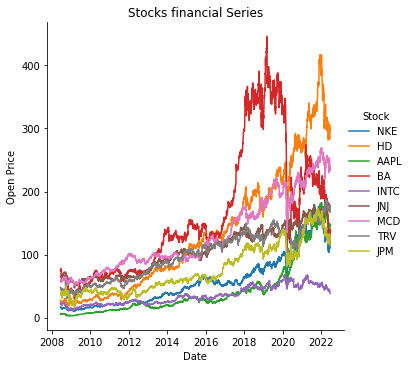

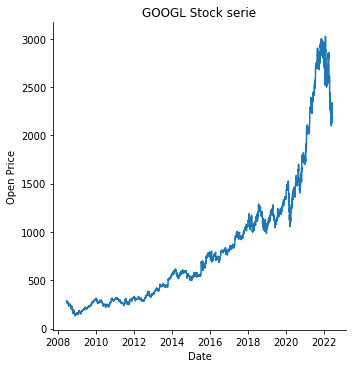

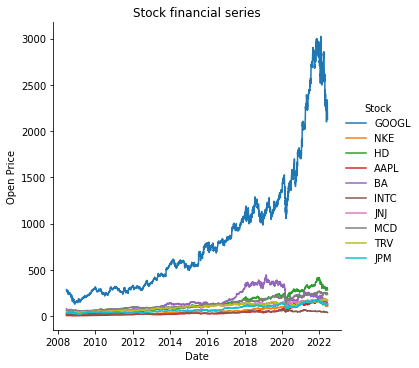

In [19]:
sns.relplot(x="Date", y="Open", data=Series[Series['Stock']!="GOOGL"], kind="line", hue="Stock")
plt.ylabel("Open Price")
plt.title("Stocks Financial Series")
sns.relplot(x="Date", y="Open", data=Series[Series['Stock']=="GOOGL"], kind = "line")
plt.title("GOOGL Stock serie")
plt.ylabel("Open Price")
#------- serie insieme -----------------
sns.relplot(x="Date", y="Open", data=Series, kind='line', hue="Stock")
plt.title("Stock Financial Feries")
plt.ylabel("Open Price")

In [10]:
# ACF E PACF di ogni serie; utile anche a capire l'ordine del modello ARIMA
